# Background

type stuff here

## Problem Statement

type stuff here

## Contents

type stuff here

## Data Dictionary

type stuff here

# Data Cleaning

In this section, we will be cleaning the 4 datasets provided. 

Summary of what was cleaned: 
* Null values 
* Lower case titles
* Change data types

In [1]:
# import all libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

# !pip install suntime
from suntime import Sun, SunTimeException
from pytz import timezone
import pytz

# allow pandas to display all columns as dataset has a total of 81 columns
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 150)

In [2]:
# import all datasets

weather = pd.read_csv("data/weather.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
spray = pd.read_csv("data/spray.csv")

# harry only
# weather = pd.read_csv("../datasets/weather.csv")
# train = pd.read_csv("../datasets/train.csv")
# test = pd.read_csv("../datasets/test.csv")
# spray = pd.read_csv("../datasets/spray.csv")

### Functions for cleaning

In [3]:
def check_missing_data(column):
    return weather[weather[column] == "M"]

In [4]:
def impute_missing_data(column):
    for k, v in enumerate(weather[column]):
        if v == "M" and weather.iloc[k]["Station"] == 1:
            weather.loc[k, column] = weather[column][k + 1]
        if v == "M" and weather.iloc[k]["Station"] == 2:
            weather.loc[k, column] = weather[column][k - 1]
    weather[column] = weather[column].astype(int)

In [5]:
def impute_missing_float_data(column):
    for k, v in enumerate(weather[column]):
        if v == "M" and weather.iloc[k]["Station"] == 1:
            weather.loc[k, column] = weather[column][k + 1]
        if v == "M" and weather.iloc[k]["Station"] == 2:
            weather.loc[k, column] = weather[column][k - 1]
    weather[column] = weather[column].astype(float)

In [6]:
def to_celsius(temp):
    celsius = ((temp - 32.0) * 5.0) / 9.0
    return float(celsius)

In [7]:
def humidity(row):
    row["Humidity"] = round(
        100
        * (
            np.exp((17.625 * row["DewPoint"]) / (243.04 + row["DewPoint"]))
            / np.exp((17.625 * row["Tavg"]) / (243.04 + row["Tavg"]))
        )
    )
    return row

In [8]:
def daylength(time):
    min = (time // 100) * 60
    min += time % 100
    return min

In [9]:
def proper_code(string):
    lst = []
    for word in string.split(" "):
        if len(word) > 3:
            lst.extend([word[:2], word[2:]])
        else:
            lst.append(word)
    lst = list(set(lst))
    return " ".join(lst)

In [10]:
def cleaner(df):
    # change title to lower case
    df.columns = df.columns.str.lower()

    # drop unnecessary columns
    try:
        df.drop(
            columns=[
                "addressaccuracy",
                "addressnumberandstreet",
                "address",
                "block",
                "street",
            ],
            inplace=True,
        )
    except KeyError:
        pass

    # convert date time
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

    # create year, month/week in dataset
    df["year"] = (df["date"].dt.strftime("%Y")).astype(int)
    df["weekofyear"] = df.date.dt.isocalendar().week

    # total mozzies as integer
    try:
        df["nummosquitos"] = df["nummosquitos"].astype("int64")
    except KeyError:
        pass

    # display final datatypes
    display(df.dtypes)


# keep in mind final submission is ID, prediction

## Weather

### Weather DataFrame

In [11]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [12]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [14]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [15]:
weather.isin(["  T"]).sum()[weather.isin(["  T"]).sum() > 0]

SnowFall        12
PrecipTotal    318
dtype: int64

In [16]:
weather.isin(["M"]).sum()[weather.isin(["M"]).sum() > 0]

Tavg             11
Depart         1472
WetBulb           4
Heat             11
Cool             11
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
AvgSpeed          3
dtype: int64

### Date

In [17]:
# Convert date to datetime
weather["Date"] = pd.to_datetime(weather["Date"], format="%Y-%m-%d")

### Tavg
Tavg is the average of Tmin and Tmax, hence we will impute Tavg with the mean of Tmin and Tmax.

In [18]:
check_missing_data("Tavg")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0.00,29.30,29.96,10.9,33,11.0
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0.00,29.39,M,4.7,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0.00,29.33,30.00,5.8,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.1,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.7,23,11.9


In [19]:
weather["Tavg"] = weather.apply(
    lambda x: (x.Tmax + x.Tmin) / 2 if x.Tavg == "M" else x.Tavg, axis=1
)

In [20]:
weather["Tavg"] = weather["Tavg"].astype(float)

In [21]:
weather["Tavg"].dtype

dtype('float64')

### Tmin

In [22]:
weather["Tmin"] = weather["Tmin"].astype(float)

### Tmax

In [23]:
weather["Tmax"] = weather["Tmax"].astype(float)

### Depart

In [24]:
check_missing_data("Depart")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84.0,52.0,68.0,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60.0,43.0,52.0,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67.0,48.0,58.0,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78.0,51.0,64.5,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66.0,54.0,60.0,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79.0,54.0,67.0,M,52,59,0,2,-,-,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6
2937,2,2014-10-28,66.0,48.0,57.0,M,40,48,8,0,-,-,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6
2939,2,2014-10-29,49.0,40.0,45.0,M,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2941,2,2014-10-30,53.0,37.0,45.0,M,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.9,23,6.5


In [25]:
impute_missing_data("Depart")

In [26]:
weather["Depart"].dtype

dtype('int32')

### WetBulb

In [27]:
check_missing_data("WetBulb")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86.0,69.0,78.0,7,60,M,0,13,0418,1931,,0,M,0.0,0.00,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81.0,64.0,73.0,0,57,M,0,8,0454,1900,,0,M,0.0,0.00,M,30.08,5.3,5,6.5
2412,1,2013-08-11,81.0,60.0,71.0,-2,61,M,0,6,0455,1859,RA,0,M,0.0,0.01,29.35,30.07,2.0,27,3.0
2415,2,2013-08-12,85.0,69.0,77.0,2,63,M,0,12,-,-,RA,M,M,M,0.66,29.27,29.92,4.5,26,7.7


In [28]:
impute_missing_data("WetBulb")

In [29]:
weather["WetBulb"].dtype

dtype('int32')

### Heat

In [30]:
check_missing_data("Heat")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78.0,51.0,64.5,4,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
505,2,2008-07-08,86.0,46.0,66.0,5,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
675,2,2008-10-01,62.0,46.0,54.0,-4,41,47,M,M,-,-,,M,M,M,0.00,29.30,29.96,10.9,33,11.0
1637,2,2011-07-22,100.0,71.0,85.5,5,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2067,2,2012-08-22,84.0,72.0,78.0,-1,51,61,M,M,-,-,,M,M,M,0.00,29.39,M,4.7,19,M
2211,2,2013-05-02,71.0,42.0,56.5,-5,39,45,M,M,-,-,,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2501,2,2013-09-24,91.0,52.0,71.5,-1,48,54,M,M,-,-,,M,M,M,0.00,29.33,30.00,5.8,9,7.7
2511,2,2013-09-29,84.0,53.0,68.5,1,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2525,2,2013-10-06,76.0,48.0,62.0,-1,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.1,25,10.6
2579,2,2014-05-02,80.0,47.0,63.5,-4,43,47,M,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.7,23,11.9


In [31]:
impute_missing_data("Heat")

In [32]:
weather["Heat"].dtype

dtype('int32')

### Cool

In [33]:
check_missing_data("Cool")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78.0,51.0,64.5,4,42,50,7,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
505,2,2008-07-08,86.0,46.0,66.0,5,68,71,0,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
675,2,2008-10-01,62.0,46.0,54.0,-4,41,47,11,M,-,-,,M,M,M,0.00,29.30,29.96,10.9,33,11.0
1637,2,2011-07-22,100.0,71.0,85.5,5,70,74,0,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2067,2,2012-08-22,84.0,72.0,78.0,-1,51,61,0,M,-,-,,M,M,M,0.00,29.39,M,4.7,19,M
2211,2,2013-05-02,71.0,42.0,56.5,-5,39,45,16,M,-,-,,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2501,2,2013-09-24,91.0,52.0,71.5,-1,48,54,5,M,-,-,,M,M,M,0.00,29.33,30.00,5.8,9,7.7
2511,2,2013-09-29,84.0,53.0,68.5,1,48,54,5,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2525,2,2013-10-06,76.0,48.0,62.0,-1,44,50,10,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.1,25,10.6
2579,2,2014-05-02,80.0,47.0,63.5,-4,43,47,15,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.7,23,11.9


In [34]:
impute_missing_data("Cool")

In [35]:
weather["Cool"].dtype

dtype('int32')

### Sunrise and Sunset

In [36]:
weather[weather["Sunrise"] == "-"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84.0,52.0,68.0,14,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60.0,43.0,52.0,-3,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67.0,48.0,58.0,2,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78.0,51.0,64.5,4,42,50,7,0,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66.0,54.0,60.0,5,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79.0,54.0,67.0,16,52,59,0,2,-,-,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6
2937,2,2014-10-28,66.0,48.0,57.0,10,40,48,8,0,-,-,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6
2939,2,2014-10-29,49.0,40.0,45.0,-4,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2941,2,2014-10-30,53.0,37.0,45.0,-4,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.9,23,6.5


In [37]:
weather[weather["Sunset"] == "-"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84.0,52.0,68.0,14,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60.0,43.0,52.0,-3,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67.0,48.0,58.0,2,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78.0,51.0,64.5,4,42,50,7,0,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66.0,54.0,60.0,5,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79.0,54.0,67.0,16,52,59,0,2,-,-,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6
2937,2,2014-10-28,66.0,48.0,57.0,10,40,48,8,0,-,-,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6
2939,2,2014-10-29,49.0,40.0,45.0,-4,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2941,2,2014-10-30,53.0,37.0,45.0,-4,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.9,23,6.5


In [38]:
latitude = 41.786
longitude = -87.752

sun = Sun(latitude, longitude)

central = timezone("US/Central")

sunrise_list = []
sunset_list = []
for value in weather["Date"]:
    abd = value
    abd_sr = sun.get_local_sunrise_time(value, local_time_zone=central)
    abd_sr = abd_sr - abd_sr.dst()
    abd_ss = sun.get_local_sunset_time(value, local_time_zone=central)
    abd_ss = abd_ss - abd_ss.dst()
    sunrise_list.append(abd_sr.strftime("%H%M"))
    sunset_list.append(abd_ss.strftime("%H%M"))

In [39]:
index = weather.loc[weather["Station"] == 2].index

for i in index:
    weather.loc[i, "Sunrise"] = sunrise_list[i]
    weather.loc[i, "Sunset"] = sunset_list[i]

In [40]:
# Check updated values
weather[["Sunrise", "Sunset"]][weather["Station"] == 2]

,Sunrise,Sunset
1,0448,1849
3,0447,1850
5,0445,1851
7,0444,1852
9,0443,1853
...,...,...
2935,0617,1652
2937,0618,1651
2939,0620,1649
2941,0621,1648


### SnowFall
'T' which represents 'Trace', denotes that there is an amount of precipitation, which is greater than zero but is too small to be measured. The lowest value in SnowFall is 0 and the second lowest is 0.1, hence we will impute 'T' with the mean of these 2 numbers, which is 0.05.

In [41]:
weather.loc[weather["SnowFall"] == "  T", "SnowFall"] = 0.05

In [42]:
check_missing_data("SnowFall")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84.0,52.0,68.0,14,51,57,0,3,0448,1849,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60.0,43.0,52.0,-3,42,47,13,0,0447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67.0,48.0,58.0,2,40,50,7,0,0445,1851,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78.0,51.0,64.5,4,42,50,7,0,0444,1852,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66.0,54.0,60.0,5,39,50,5,0,0443,1853,,M,M,M,T,29.46,30.09,11.2,7,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79.0,54.0,67.0,16,52,59,0,2,0617,1652,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6
2937,2,2014-10-28,66.0,48.0,57.0,10,40,48,8,0,0618,1651,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6
2939,2,2014-10-29,49.0,40.0,45.0,-4,34,42,20,0,0620,1649,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2941,2,2014-10-30,53.0,37.0,45.0,-4,35,42,20,0,0621,1648,RA,M,M,M,T,29.41,30.10,5.9,23,6.5


In [43]:
impute_missing_float_data("SnowFall")

In [44]:
weather["SnowFall"].value_counts()

0.00    2918
0.05      24
0.10       2
Name: SnowFall, dtype: int64

In [45]:
# Minimal snow, can drop column

weather["SnowFall"].sum()

1.4

### PrecipTotal
'T' which represents 'Trace', denotes that there is an amount of precipitation, which is greater than zero but is too small to be measured. The lowest value in PrecipTotal is 0 and the second lowest is 0.01, hence we will impute 'T' with the mean of these 2 numbers, which is 0.005.

In [46]:
weather["PrecipTotal"].value_counts(ascending=False)

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
3.66       1
0.90       1
1.19       1
1.07       1
2.06       1
Name: PrecipTotal, Length: 168, dtype: int64

In [47]:
weather.loc[weather["PrecipTotal"] == "  T", "PrecipTotal"] = 0.005

In [48]:
check_missing_data("PrecipTotal")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
117,2,2007-06-28,73.0,61.0,67.0,-5,56,61,0,2,0419,1930,,M,M,0.0,M,29.43,30.07,12.2,2,13.3
119,2,2007-06-29,71.0,56.0,64.0,-8,56,60,1,0,0419,1930,,M,M,0.0,M,29.47,30.11,7.4,2,8.2


In [49]:
impute_missing_float_data("PrecipTotal")

In [50]:
weather["PrecipTotal"] = weather["PrecipTotal"].astype(float)

### Depth
Depth has only 2 values. 'M' which denotes missing data or 0. We will look into dropping this column since it does not hold any meaningful data. Meanwhile, we will impute the values with 0 from the other Station.

In [51]:
weather["Depth"].value_counts()

M    1472
0    1472
Name: Depth, dtype: int64

In [52]:
impute_missing_data("Depth")

In [53]:
weather["Depth"].dtype

dtype('int32')

### StnPressure

In [54]:
check_missing_data("StnPressure")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86.0,68.0,77.0,6,53,62,0,12,0416,1926,,0,M,0.0,0.0,M,M,7.0,5,M
848,1,2009-06-26,86.0,69.0,78.0,7,60,67,0,13,0418,1931,,0,M,0.0,0.0,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81.0,64.0,73.0,0,57,63,0,8,0454,1900,,0,M,0.0,0.0,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81.0,68.0,75.0,0,55,63,0,10,0454,1858,,0,M,0.0,0.0,M,30.07,6.0,6,7.4


In [55]:
weather[weather["StnPressure"] == "M"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86.0,68.0,77.0,6,53,62,0,12,0416,1926,,0,M,0.0,0.0,M,M,7.0,5,M
848,1,2009-06-26,86.0,69.0,78.0,7,60,67,0,13,0418,1931,,0,M,0.0,0.0,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81.0,64.0,73.0,0,57,63,0,8,0454,1900,,0,M,0.0,0.0,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81.0,68.0,75.0,0,55,63,0,10,0454,1858,,0,M,0.0,0.0,M,30.07,6.0,6,7.4


Data could not be imputed using data from the other Station as both rows do not have any values in 'StnPressure'. Hence, we will check for the 'StnPressure' for the day before and the day after, and impute the missing data with the mean of 'StnPressure' of these two days.

In [56]:
weather[weather["Date"] == "2013-08-10"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2410,1,2013-08-10,81.0,64.0,73.0,0,57,63,0,8,0454,1900,,0,M,0.0,0.0,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81.0,68.0,75.0,0,55,63,0,10,0454,1858,,0,M,0.0,0.0,M,30.07,6.0,6,7.4


In [57]:
weather[weather["Date"] == "2013-08-09"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2408,1,2013-08-09,82.0,59.0,71.0,-2,60,65,0,6,0453,1902,,0,M,0.0,0.005,29.28,29.98,4.7,27,5.3
2409,2,2013-08-09,84.0,62.0,73.0,-2,58,65,0,8,0453,1859,,0,M,0.0,0.000,29.34,29.97,4.9,27,5.6


In [58]:
weather[weather["Date"] == "2013-08-11"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2412,1,2013-08-11,81.0,60.0,71.0,-2,61,64,0,6,0455,1859,RA,0,M,0.0,0.010,29.35,30.07,2.0,27,3.0
2413,2,2013-08-11,84.0,63.0,74.0,-2,57,64,0,9,0455,1857,,0,M,0.0,0.005,29.42,30.06,4.0,24,5.4


In [59]:
# Impute according to the average StnPressure of 2013-08-09 and 2013-08-11
weather.at[2410, "StnPressure"] = round((29.28 + 29.34) / 2, 2)
weather.at[2411, "StnPressure"] = round((29.35 + 29.42) / 2, 2)

In [60]:
weather[weather["Date"] == "2013-08-10"]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2410,1,2013-08-10,81.0,64.0,73.0,0,57,63,0,8,0454,1900,,0,M,0.0,0.0,29.31,30.08,5.3,5,6.5
2411,2,2013-08-10,81.0,68.0,75.0,0,55,63,0,10,0454,1858,,0,M,0.0,0.0,29.39,30.07,6.0,6,7.4


In [61]:
impute_missing_float_data("StnPressure")

### SeaLevel

In [62]:
check_missing_data("SeaLevel")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86.0,68.0,77.0,6,53,62,0,12,0416,1926,,0,M,0.0,0.000,29.36,M,7.0,5,M
832,1,2009-06-18,80.0,61.0,71.0,1,63,67,0,6,0416,1929,RA BR,0,M,0.0,0.120,29.08,M,6.7,16,7.9
994,1,2009-09-07,77.0,59.0,68.0,1,59,62,0,3,0523,1817,BR,0,M,0.0,0.000,29.39,M,5.8,3,4.0
1732,1,2011-09-08,75.0,57.0,66.0,0,53,59,0,1,0524,1815,RA,0,M,0.0,0.005,29.34,M,13.0,2,13.4
1745,2,2011-09-14,60.0,48.0,54.0,-11,45,51,11,0,0530,1802,RA BR HZ FU,0,M,0.0,0.005,29.47,M,6.0,32,M
1756,1,2011-09-20,74.0,49.0,62.0,0,54,58,3,0,0537,1753,MIFG BCFG BR,0,M,0.0,0.000,29.26,M,7.3,18,7.3
2067,2,2012-08-22,84.0,72.0,78.0,-1,51,61,0,5,0507,1839,,0,M,0.0,0.000,29.39,M,4.7,19,M
2090,1,2012-09-03,88.0,71.0,80.0,12,70,73,0,15,0519,1824,BR,0,M,0.0,0.000,29.17,M,4.6,6,4.4
2743,2,2014-07-23,76.0,64.0,70.0,-7,56,61,0,5,0436,1918,,0,M,0.0,0.000,29.47,M,16.4,2,16.7


In [63]:
impute_missing_float_data("SeaLevel")

In [64]:
weather["SeaLevel"] = weather["SeaLevel"].astype(float)

### AvgSpeed

In [65]:
check_missing_data("AvgSpeed")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86.0,68.0,77.0,6,53,62,0,12,0416,1926,,0,M,0.0,0.000,29.36,30.09,7.0,5,M
1745,2,2011-09-14,60.0,48.0,54.0,-11,45,51,11,0,0530,1802,RA BR HZ FU,0,M,0.0,0.005,29.47,30.09,6.0,32,M
2067,2,2012-08-22,84.0,72.0,78.0,-1,51,61,0,5,0507,1839,,0,M,0.0,0.000,29.39,30.07,4.7,19,M


In [66]:
impute_missing_float_data("AvgSpeed")

In [67]:
weather["AvgSpeed"] = weather["AvgSpeed"].astype(float)

In [68]:
weather.isin(["  T"]).sum()[weather.isin(["  T"]).sum() > 0]

Series([], dtype: int64)

In [69]:
weather.isin(["M"]).sum()[weather.isin(["M"]).sum() > 0]

Water1    2944
dtype: int64

### Relative Humidity
Formula to calculate humidity: [source](https://bmcnoldy.rsmas.miami.edu/Humidity.html)

In [70]:
weather["Tavg"] = weather["Tavg"].apply(to_celsius)
weather["Tmin"] = weather["Tmin"].apply(to_celsius)
weather["Tmax"] = weather["Tmax"].apply(to_celsius)

In [71]:
weather["DewPoint"] = weather["DewPoint"].apply(to_celsius)

In [72]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   float64       
 3   Tmin         2944 non-null   float64       
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   int32         
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   int32         
 8   Heat         2944 non-null   int32         
 9   Cool         2944 non-null   int32         
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int32         
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   float64       
 16  Precip

In [73]:
weather = weather.apply(humidity, axis=1)

In [74]:
weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Humidity
0,1,2007-05-01,28.333333,10.000000,19.444444,14,10.555556,56,0,2,0448,1849,,0,M,0.0,0.000,29.10,29.82,1.7,27,9.2,56
1,2,2007-05-01,28.888889,11.111111,20.000000,14,10.555556,57,0,3,0448,1849,,0,M,0.0,0.000,29.18,29.82,2.7,25,9.6,55
2,1,2007-05-02,15.000000,5.555556,10.555556,-3,5.555556,47,14,0,0447,1850,BR,0,M,0.0,0.000,29.38,30.09,13.0,4,13.4,71
3,2,2007-05-02,15.555556,6.111111,11.111111,-3,5.555556,47,13,0,0447,1850,BR HZ,0,M,0.0,0.000,29.44,30.08,13.3,2,13.4,69
4,1,2007-05-03,18.888889,7.777778,13.333333,2,4.444444,48,9,0,0446,1851,,0,M,0.0,0.000,29.39,30.12,11.7,7,11.9,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,9.444444,4.444444,7.222222,-4,1.111111,42,20,0,0620,1649,,0,M,0.0,0.000,29.42,30.07,8.5,29,9.0,65
2940,1,2014-10-30,10.555556,0.000000,5.555556,-4,1.111111,40,23,0,0622,1649,,0,M,0.0,0.000,29.34,30.09,5.1,24,5.5,73
2941,2,2014-10-30,11.666667,2.777778,7.222222,-4,1.666667,42,20,0,0621,1648,RA,0,M,0.0,0.005,29.41,30.10,5.9,23,6.5,68
2942,1,2014-10-31,8.333333,0.555556,4.444444,-6,-3.888889,33,25,0,0623,1647,RA SN,0,M,0.1,0.030,29.49,30.20,22.6,34,22.9,55


In [75]:
weather["Humidity"].value_counts()

59     116
62     113
60     107
65     102
56     100
58      98
64      97
69      95
55      93
67      93
68      90
52      89
61      88
57      87
66      87
71      85
53      85
74      80
63      80
54      80
50      67
76      64
51      61
73      59
47      59
48      50
49      48
70      45
72      44
78      44
75      42
81      39
46      39
84      35
79      34
43      31
45      27
77      27
44      25
87      24
80      22
83      22
41      21
90      18
42      18
40      16
93      14
86      14
39       9
82       9
38       9
89       8
37       7
35       5
85       5
32       3
36       3
34       3
96       2
33       2
30       1
102      1
104      1
100      1
107      1
Name: Humidity, dtype: int64

In [76]:
weather["Sunrise"] = weather["Sunrise"].apply(pd.to_numeric)
weather["Sunset"] = weather["Sunset"].apply(pd.to_numeric)

In [77]:
weather["daylength"] = weather.apply(
    lambda row: daylength(row["Sunset"]) - daylength(row["Sunrise"]), axis=1
)

### Merge Station 1 and 2

In [78]:
weather_2 = weather.groupby("Date").sum() / 2
weather_2 = weather_2.drop(columns=["Station"]).reset_index()

In [79]:
weather_2.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Humidity,daylength
0,2007-05-01,28.611111,10.555556,19.722222,14.0,10.555556,56.5,0.0,2.5,448.0,1849.0,0.0,0.0,0.0000,29.140,29.820,2.20,26.0,9.40,55.5,841.0
1,2007-05-02,15.277778,5.833333,10.833333,-3.0,5.555556,47.0,13.5,0.0,447.0,1850.0,0.0,0.0,0.0000,29.410,30.085,13.15,3.0,13.40,70.0,843.0
2,2007-05-03,19.166667,8.333333,13.888889,2.0,4.444444,49.0,8.0,0.0,445.5,1851.0,0.0,0.0,0.0000,29.425,30.120,12.30,6.5,12.55,53.0,845.5
3,2007-05-04,22.222222,10.000000,16.250000,4.0,5.277778,50.0,7.0,0.0,444.0,1852.0,0.0,0.0,0.0025,29.335,30.045,10.25,7.5,10.60,48.5,848.0
4,2007-05-05,18.888889,11.944444,15.555556,5.0,3.611111,49.5,5.0,0.0,443.0,1853.0,0.0,0.0,0.0050,29.430,30.095,11.45,7.0,11.75,45.0,850.0


In [80]:
weather_2.shape

(1472, 21)

In [81]:
weather.shape

(2944, 24)

In [82]:
weather.head(40)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Humidity,daylength
0,1,2007-05-01,28.333333,10.000000,19.444444,14,10.555556,56,0,2,448,1849,,0,M,0.0,0.000,29.10,29.82,1.7,27,9.2,56,841
1,2,2007-05-01,28.888889,11.111111,20.000000,14,10.555556,57,0,3,448,1849,,0,M,0.0,0.000,29.18,29.82,2.7,25,9.6,55,841
2,1,2007-05-02,15.000000,5.555556,10.555556,-3,5.555556,47,14,0,447,1850,BR,0,M,0.0,0.000,29.38,30.09,13.0,4,13.4,71,843
3,2,2007-05-02,15.555556,6.111111,11.111111,-3,5.555556,47,13,0,447,1850,BR HZ,0,M,0.0,0.000,29.44,30.08,13.3,2,13.4,69,843
4,1,2007-05-03,18.888889,7.777778,13.333333,2,4.444444,48,9,0,446,1851,,0,M,0.0,0.000,29.39,30.12,11.7,7,11.9,55,845
5,2,2007-05-03,19.444444,8.888889,14.444444,2,4.444444,50,7,0,445,1851,HZ,0,M,0.0,0.000,29.46,30.12,12.9,6,13.2,51,846
6,1,2007-05-04,18.888889,9.444444,14.444444,4,5.000000,50,7,0,444,1852,RA,0,M,0.0,0.005,29.31,30.05,10.4,8,10.8,53,848
7,2,2007-05-04,25.555556,10.555556,18.055556,4,5.555556,50,7,0,444,1852,,0,M,0.0,0.000,29.36,30.04,10.1,7,10.4,44,848
8,1,2007-05-05,18.888889,11.666667,15.555556,5,3.333333,49,5,0,443,1853,,0,M,0.0,0.005,29.40,30.10,11.7,7,12.0,44,850
9,2,2007-05-05,18.888889,12.222222,15.555556,5,3.888889,50,5,0,443,1853,,0,M,0.0,0.005,29.46,30.09,11.2,7,11.5,46,850


In [83]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   float64       
 3   Tmin         2944 non-null   float64       
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   int64         
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   int64         
 8   Heat         2944 non-null   int64         
 9   Cool         2944 non-null   int64         
 10  Sunrise      2944 non-null   int64         
 11  Sunset       2944 non-null   int64         
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int64         
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   float64       
 16  Precip

In [84]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Humidity,daylength
0,1,2007-05-01,28.333333,10.000000,19.444444,14,10.555556,56,0,2,448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,56,841
1,2,2007-05-01,28.888889,11.111111,20.000000,14,10.555556,57,0,3,448,1849,,0,M,0.0,0.0,29.18,29.82,2.7,25,9.6,55,841
2,1,2007-05-02,15.000000,5.555556,10.555556,-3,5.555556,47,14,0,447,1850,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4,71,843
3,2,2007-05-02,15.555556,6.111111,11.111111,-3,5.555556,47,13,0,447,1850,BR HZ,0,M,0.0,0.0,29.44,30.08,13.3,2,13.4,69,843
4,1,2007-05-03,18.888889,7.777778,13.333333,2,4.444444,48,9,0,446,1851,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9,55,845


In [85]:
set(weather.columns) - set(weather_2.columns)

{'CodeSum', 'Station', 'Water1'}

In [86]:
temp = pd.Series([], name="CodeSum", dtype="str")
for i in range(0, len(weather), 2):
    temp[i / 2] = " ".join(
        set(weather.loc[i, "CodeSum"].split()).union(
            set(weather.loc[i + 1, "CodeSum"].split())
        )
    )

In [87]:
weather_2 = weather_2.merge(temp, left_index=True, right_index=True)

In [88]:
weather_2["CodeSum"] = weather_2["CodeSum"].apply(proper_code)

### Drop Columns 
* Water1
* Depth
* WetBulb
* CodeSum
* Heat
* Cool
* DewPoint
* SnowFall

In [89]:
weather_2 = weather_2.drop(
    columns=[
        "Depth",
        "WetBulb",  # already have humidity
        "CodeSum",
        "Heat",
        "Cool",
        "DewPoint",  # already have humidity
        "SnowFall",
        "Tmin",  # use Tavg instead
        "Tmax",
        "Depart",
        "Sunrise",  # dropped because we already have daylength
        "Sunset",
    ]
)

In [90]:
weather_2

,Date,Tavg,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Humidity,daylength
0,2007-05-01,19.722222,0.0000,29.140,29.820,2.20,26.0,9.40,55.5,841.0
1,2007-05-02,10.833333,0.0000,29.410,30.085,13.15,3.0,13.40,70.0,843.0
2,2007-05-03,13.888889,0.0000,29.425,30.120,12.30,6.5,12.55,53.0,845.5
3,2007-05-04,16.250000,0.0025,29.335,30.045,10.25,7.5,10.60,48.5,848.0
4,2007-05-05,15.555556,0.0050,29.430,30.095,11.45,7.0,11.75,45.0,850.0
...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,18.611111,0.0100,28.960,29.665,12.35,19.0,13.25,61.0,635.0
1468,2014-10-28,13.888889,0.0175,29.190,29.850,14.40,26.0,15.10,51.0,632.5
1469,2014-10-29,6.666667,0.0000,29.390,30.065,9.00,29.0,9.45,65.0,629.5
1470,2014-10-30,6.388889,0.0025,29.375,30.095,5.50,23.5,6.00,70.5,627.0


### To do:  
check wind columns -> which should we keep
stn pressure?
sea level?

## Spray

In [91]:
spray.shape

(14835, 4)

In [92]:
spray.dropna(inplace=True)

# also drop time column as this is not present in any other dataset
spray.drop(columns="Time", inplace=True)

In [93]:
spray.shape

(14251, 3)

In [94]:
cleaner(spray)

date          datetime64[ns]
latitude             float64
longitude            float64
year                   int32
weekofyear            UInt32
dtype: object

In [95]:
spray.drop_duplicates(inplace=True)
spray.shape

(13710, 5)

## Train

### Train Dataframe

In [96]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [97]:
train.shape

(10506, 12)

In [98]:
# create combined coordinates
train['latlong'] = train["Latitude"].astype(str) + ", " + train["Longitude"].astype(str)

### NumMosquitos

This section checks the duplicate rows for mosquito count. 

In Kaggle, it is stated that each row has a maximum count of 50 rows. Anything more than 50 will be split into a different row. 

We will be aggregating these into a new column called 'nummosquitos'.

In [99]:
# check total mosquitoes in sample
train["NumMosquitos"].sum()

135039

In [100]:
# duplicated rows with less than 50 mosquitoes
duplicates = train[(train.duplicated())]

duplicates["NumMosquitos"].sum()

36068

In [101]:
# Prevent issue where one unique trap, species and date has 2 rows if wnv = 1 in one observation 
# and 0 in another
train = train.groupby([col for col in train.columns if col not in ['NumMosquitos',\
                                    'WnvPresent']], as_index=False).sum().reindex()


# Re-binarize wnvpresent column as it now has values more than 1
train['WnvPresent'] = train['WnvPresent'].map(lambda x: 1 if x > 0 else 0)

In [102]:
train["NumMosquitos"].sum()

135039

In [103]:
train[train.duplicated()]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,latlong,NumMosquitos,WnvPresent


In [104]:
# use cleaner function
cleaner(train)

date            datetime64[ns]
species                 object
trap                    object
latitude               float64
longitude              float64
latlong                 object
nummosquitos             int64
wnvpresent               int64
year                     int32
weekofyear              UInt32
dtype: object

### Species

Only 3 species from the train data set seem to be carriers of the WNV: 
* Culex Pipens/Restuans
* Culex Restuans
* Culex Pipiens

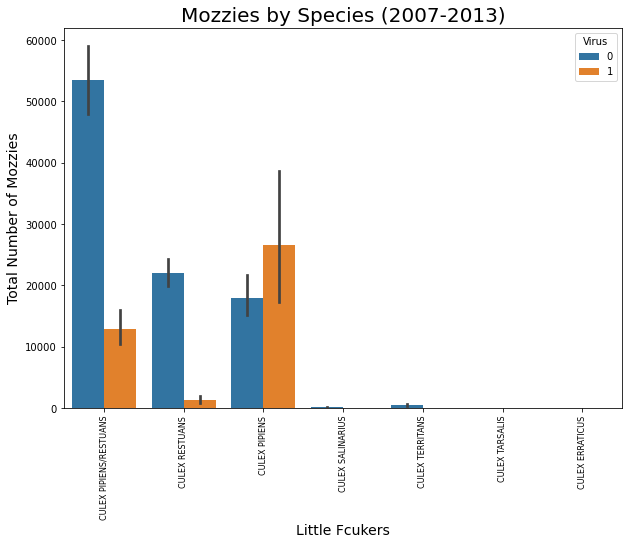

In [105]:
# show total mozzies by species

plt.figure(figsize=(10, 7))
plot = sns.barplot(
    x="species", y="nummosquitos", hue="wnvpresent", data=train, estimator=sum
)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Total Number of Mozzies", fontsize=14)
plt.xlabel("Little Fcukers", fontsize=14)
plt.legend(loc="upper right", title="Virus")
plt.title("Mozzies by Species (2007-2013)", fontsize=20)
plt.show()

In [106]:
# Percentage of species with WNV

wnv_species = ["CULEX PIPIENS/RESTUANS", "CULEX PIPIENS", "CULEX RESTUANS"]

for i in wnv_species:
    percent = round(
        (
            (
                train[(train["wnvpresent"] == 1) & (train["species"] == str(i))][
                    "nummosquitos"
                ].sum()
            )
            / (train[train["species"] == str(i)]["nummosquitos"].sum())
            * 100
        ),
        2,
    )
    print(f"Percentage of {i} with west nile virus is: {percent}%")

Percentage of CULEX PIPIENS/RESTUANS with west nile virus is: 19.39%
Percentage of CULEX PIPIENS with west nile virus is: 59.65%
Percentage of CULEX RESTUANS with west nile virus is: 5.76%


In [107]:
# culex pipiens and culex pipiens/restuans are similar in terms of being carriers of the virus

# dummify these variables using a function

train["dum_species"] = train["species"].map(
    {"CULEX PIPIENS/RESTUANS": 1, "CULEX PIPIENS": 1, "CULEX RESTUANS": 2}
)

# 0 for species other than the virus carriers
train["dum_species"].fillna(0, inplace=True)

train["dum_species"] = train["dum_species"].astype("int64")

In [108]:
train.head()

,date,species,trap,latitude,longitude,latlong,nummosquitos,wnvpresent,year,weekofyear,dum_species
0,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,"41.867108, -87.654224",1,0,2007,22,1
1,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,"41.867108, -87.654224",2,0,2007,22,2
2,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,"41.862292, -87.64886",1,0,2007,22,2
3,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,"41.896282, -87.655232",1,0,2007,22,2
4,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,"41.907645, -87.760886",1,0,2007,22,2


### Drop Columns

* Trap (as it is already represented in latitude and longitude)

In [109]:
train.drop(columns="trap", inplace=True)

## Test

In [110]:
test.shape

(116293, 11)

In [111]:
cleaner(test)

id                     int64
date          datetime64[ns]
species               object
trap                  object
latitude             float64
longitude            float64
year                   int32
weekofyear            UInt32
dtype: object

In [112]:
test.head()

,id,date,species,trap,latitude,longitude,year,weekofyear
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,24
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,24
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,24
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,24
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,24


In [113]:
# create combined coordinates
test['latlong'] = test["latitude"].astype(str) + ", " + test["longitude"].astype(str)

In [114]:
# dummify species

test["dum_species"] = test["species"].map(
    {"CULEX PIPIENS/RESTUANS": 1, "CULEX PIPIENS": 1, "CULEX RESTUANS": 2}
)

# 0 for species other than the virus carriers
test["dum_species"].fillna(0, inplace=True)

test["dum_species"] = test["dum_species"].astype("int64")

In [115]:
# drop trap
test.drop(columns="trap", inplace=True)

In [116]:
test.head()

,id,date,species,latitude,longitude,year,weekofyear,latlong,dum_species
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",1
1,2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",2
2,3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",1
3,4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",0
4,5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",0


## Save cleaned data

In [117]:
# all cleaned original datasets

weather_2.to_csv("data/weather_clean.csv", index=False)
train.to_csv("data/train_clean.csv", index=False)
test.to_csv("data/test_clean.csv", index=False)
spray.to_csv("data/spray_clean.csv", index=False)


# harry only
# weather_2.to_csv("../datasets/weather_clean.csv", index=False)
# train.to_csv("../datasets/train_clean.csv", index=False)
# test.to_csv("../datasets/test_clean.csv", index=False)
# spray.to_csv("../datasets/spray_clean.csv", index=False)

## Combine Train/Test with Weather

In [119]:
weather = pd.read_csv("data/weather_clean.csv", parse_dates=["Date"], index_col=None)
train = pd.read_csv("data/train_clean.csv", parse_dates=["date"], index_col=None)
test = pd.read_csv("data/test_clean.csv", parse_dates=["date"], index_col=None)

# harry only
# weather = pd.read_csv("../datasets/weather_clean.csv", parse_dates=["Date"], index_col=None)
# train = pd.read_csv("../datasets/train_clean.csv", parse_dates=["date"], index_col=None)
# test = pd.read_csv("../datasets/test_clean.csv", parse_dates=["date"], index_col=None)

In [120]:
# clean weather columns
# weather.drop(columns='Unnamed: 0', inplace=True)
weather.columns = weather.columns.str.lower()

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          8475 non-null   datetime64[ns]
 1   species       8475 non-null   object        
 2   latitude      8475 non-null   float64       
 3   longitude     8475 non-null   float64       
 4   latlong       8475 non-null   object        
 5   nummosquitos  8475 non-null   int64         
 6   wnvpresent    8475 non-null   int64         
 7   year          8475 non-null   int64         
 8   weekofyear    8475 non-null   int64         
 9   dum_species   8475 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 662.2+ KB


In [122]:
# merge train dataset with weather
final_train = pd.merge(train, weather, on="date")
final_train.head()

final_train.rename(
    columns={"year_x": "year", "weekofyear_x": "weekofyear"}, inplace=True
)

final_train.head()

,date,species,latitude,longitude,latlong,nummosquitos,wnvpresent,year,weekofyear,dum_species,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,humidity,daylength
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.867108,-87.654224,"41.867108, -87.654224",1,0,2007,22,1,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
1,2007-05-29,CULEX RESTUANS,41.867108,-87.654224,"41.867108, -87.654224",2,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
2,2007-05-29,CULEX RESTUANS,41.862292,-87.648860,"41.862292, -87.64886",1,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
3,2007-05-29,CULEX RESTUANS,41.896282,-87.655232,"41.896282, -87.655232",1,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
4,2007-05-29,CULEX RESTUANS,41.907645,-87.760886,"41.907645, -87.760886",1,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5


In [123]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          8475 non-null   datetime64[ns]
 1   species       8475 non-null   object        
 2   latitude      8475 non-null   float64       
 3   longitude     8475 non-null   float64       
 4   latlong       8475 non-null   object        
 5   nummosquitos  8475 non-null   int64         
 6   wnvpresent    8475 non-null   int64         
 7   year          8475 non-null   int64         
 8   weekofyear    8475 non-null   int64         
 9   dum_species   8475 non-null   int64         
 10  tavg          8475 non-null   float64       
 11  preciptotal   8475 non-null   float64       
 12  stnpressure   8475 non-null   float64       
 13  sealevel      8475 non-null   float64       
 14  resultspeed   8475 non-null   float64       
 15  resultdir     8475 non-null   float64 

In [124]:
# merge test dataset with weather
final_test = pd.merge(test, weather, on="date")
final_test.head()

final_test.rename(
    columns={"year_x": "year", "weekofyear_x": "weekofyear"}, inplace=True
)

final_test.head()

,id,date,species,latitude,longitude,year,weekofyear,latlong,dum_species,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,humidity,daylength
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",1,23.888889,0.0,29.31,29.98,9.15,18.0,10.2,50.5,910.0
1,2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",2,23.888889,0.0,29.31,29.98,9.15,18.0,10.2,50.5,910.0
2,3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",1,23.888889,0.0,29.31,29.98,9.15,18.0,10.2,50.5,910.0
3,4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",0,23.888889,0.0,29.31,29.98,9.15,18.0,10.2,50.5,910.0
4,5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,2008,24,"41.95469, -87.800991",0,23.888889,0.0,29.31,29.98,9.15,18.0,10.2,50.5,910.0


In [125]:
final_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           116293 non-null  int64         
 1   date         116293 non-null  datetime64[ns]
 2   species      116293 non-null  object        
 3   latitude     116293 non-null  float64       
 4   longitude    116293 non-null  float64       
 5   year         116293 non-null  int64         
 6   weekofyear   116293 non-null  int64         
 7   latlong      116293 non-null  object        
 8   dum_species  116293 non-null  int64         
 9   tavg         116293 non-null  float64       
 10  preciptotal  116293 non-null  float64       
 11  stnpressure  116293 non-null  float64       
 12  sealevel     116293 non-null  float64       
 13  resultspeed  116293 non-null  float64       
 14  resultdir    116293 non-null  float64       
 15  avgspeed     116293 non-null  floa

In [126]:
# save both dataframes for feature engineering & modelling
final_train.to_csv("data/final_train.csv")
final_test.to_csv("data/final_test.csv")

#  harry only
# final_train.to_csv("../datasets/final_train.csv")
# final_test.to_csv("../datasets/final_test.csv")

# EDA

## Stuff about dem lil fkers

Over the years, number of culex pipiens seem to have decreased, but increased again in 2013. 

Culex pipiens/restuans (no idea what these are) seem to have decreased then increased again. IF this is a combination of the 2 species of mosquitoes, then the pattern we are seeing seems to be congruent with our observations for culex pipiens and culex restuans.

There seems to be no effect of spraying on culex restuans, in fact the population has steadily increased over the years. Possible things to explore: 
1) Did they develop a resistance to the sprays? 

2) Were the areas where culex restuans found even sprayed at all? 

3) Which areas were these found in? Did they have a different climate compared to the other species of mosquitoes? 

Text(0, 0.5, 'Total Number of Mozzies')

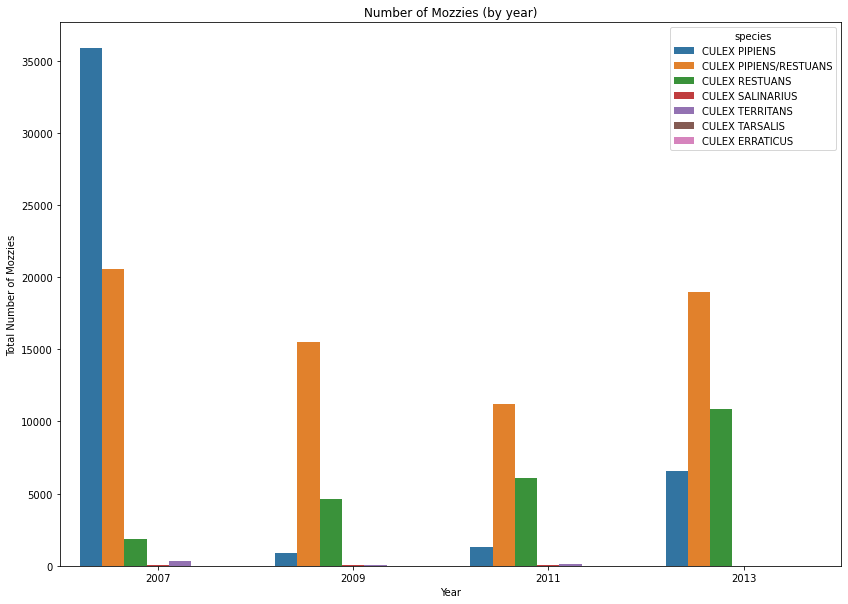

In [127]:
# species by years

moz_year = train.groupby(["year", "species"], as_index=False).sum()

plt.figure(figsize=(14, 10))
plt.title("Number of Mozzies (by year)")
sns.barplot(x="year", y="nummosquitos", hue="species", data=moz_year)
plt.xlabel("Year")
plt.ylabel("Total Number of Mozzies")

### To do: plot mozzies by area?

## Spray vs mosquito population and wnv

In [128]:
# when were sprays implemented

# Split the dataframe based on year
spray_df_2013 = spray[spray["date"].dt.year == 2013]
spray_df_2011 = spray[spray["date"].dt.year == 2011]

spray_2011 = spray_df_2011["date"].unique()[:2]
spray_2011

spray_2013 = spray_df_2013["date"].unique()[:8]
spray_2013

array(['2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

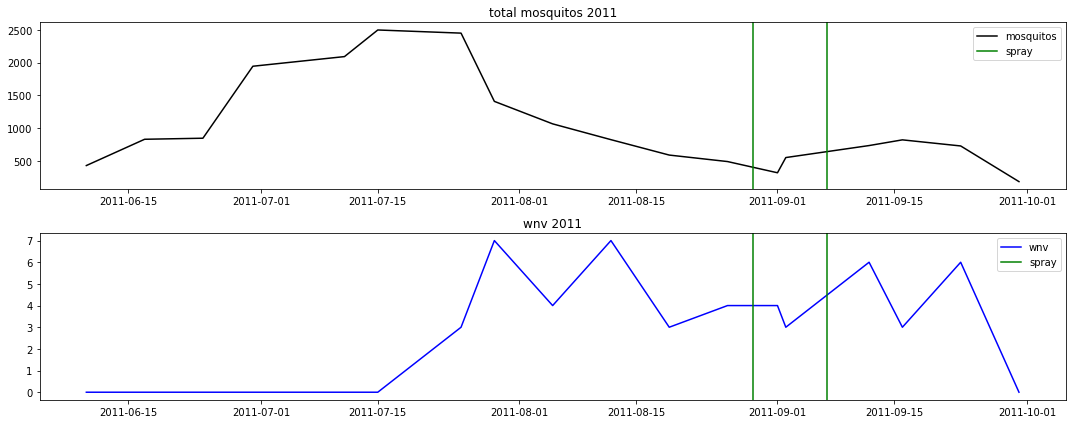

In [129]:
moz_2011 = train[train["date"].dt.year == 2011].groupby("date")["nummosquitos"].sum()
wnv_2011 = train[train["date"].dt.year == 2011].groupby("date")["wnvpresent"].sum()


fig, ax = plt.subplots(nrows=2, figsize=(15, 6))
ax[0].plot(moz_2011.index, moz_2011.values, color="black")
for date in spray_2011:
    ax[0].axvline(x=date, color="green", ls="-")
ax[0].set_title("total mosquitos 2011")
ax[0].legend(["mosquitos", "spray"], loc="upper right")


ax[1].plot(wnv_2011.index, wnv_2011.values, color="blue")
for date in spray_2011:
    ax[1].axvline(x=date, color="green", ls="-")
ax[1].set_title("wnv 2011")
ax[1].legend(["wnv", "spray"], loc="upper right")


plt.tight_layout()

Only sprayed mosquitoes twice. It did not seem to work? For the first spray, total mosquito population decreased, but WNV was constant. After the 2nd spray, both mosquito population and WNV mosquitoes went up, suggesting that 1) the sprays are not effective, or 2) there could be other factors that increased mosquito breeding / propagation of WNV. 

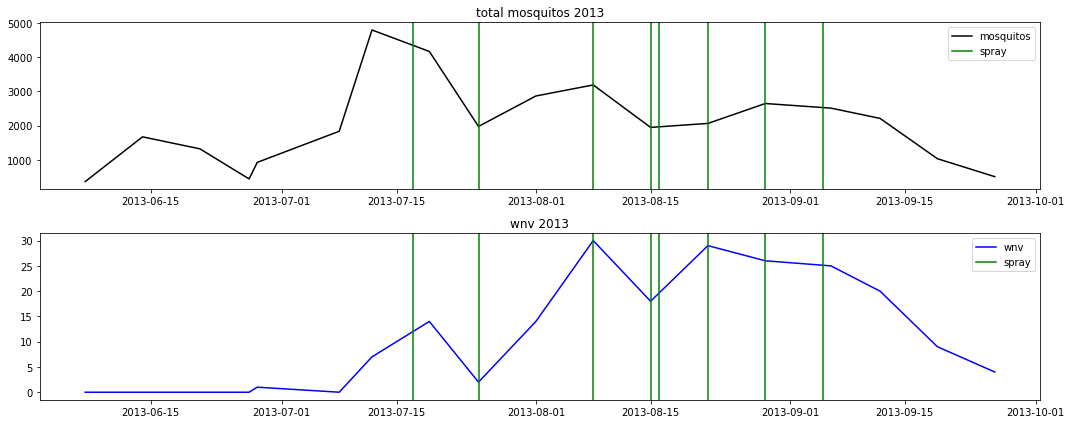

In [130]:
moz_2013 = train[train["date"].dt.year == 2013].groupby("date")["nummosquitos"].sum()
wnv_2013 = train[train["date"].dt.year == 2013].groupby("date")["wnvpresent"].sum()


fig, ax = plt.subplots(nrows=2, figsize=(15, 6))
ax[0].plot(moz_2013.index, moz_2013.values, color="black")
for date in spray_2013:
    ax[0].axvline(x=date, color="green", ls="-")
ax[0].set_title("total mosquitos 2013")
ax[0].legend(["mosquitos", "spray"], loc="upper right")


ax[1].plot(wnv_2013.index, wnv_2013.values, color="blue")
for date in spray_2013:
    ax[1].axvline(x=date, color="green", ls="-")
ax[1].set_title("wnv 2013")
ax[1].legend(["wnv", "spray"], loc="upper right")


plt.tight_layout()

For 2013, mosquitoes were sprayed mosquitoes extensively. It seemed to work in the beginning, but mid-August, despite spraying the mosquito population (that had WNV) went up although total number of mosquitoes kind of remained constant. Could it be due to weather factors? 

## Mozzies vs Weather (To do)

In [131]:
final_train.head()

,date,species,latitude,longitude,latlong,nummosquitos,wnvpresent,year,weekofyear,dum_species,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,humidity,daylength
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.867108,-87.654224,"41.867108, -87.654224",1,0,2007,22,1,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
1,2007-05-29,CULEX RESTUANS,41.867108,-87.654224,"41.867108, -87.654224",2,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
2,2007-05-29,CULEX RESTUANS,41.862292,-87.648860,"41.862292, -87.64886",1,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
3,2007-05-29,CULEX RESTUANS,41.896282,-87.655232,"41.896282, -87.655232",1,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5
4,2007-05-29,CULEX RESTUANS,41.907645,-87.760886,"41.907645, -87.760886",1,0,2007,22,2,24.166667,0.0,29.415,30.1,5.8,17.0,6.95,55.5,896.5


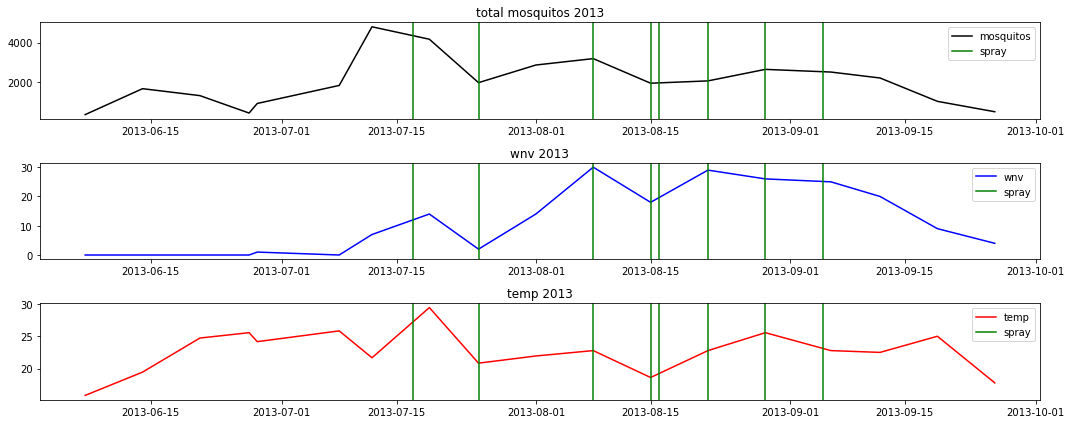

In [141]:
moz_2013 = train[train["date"].dt.year == 2013].groupby("date")["nummosquitos"].sum()
wnv_2013 = train[train["date"].dt.year == 2013].groupby("date")["wnvpresent"].sum()
temp_2013 = (
    final_train[final_train["date"].dt.year == 2013].groupby("date")["tavg"].mean()
)


fig, ax = plt.subplots(nrows=3, figsize=(15, 6))
ax[0].plot(moz_2013.index, moz_2013.values, color="black")
for date in spray_2013:
    ax[0].axvline(x=date, color="green", ls="-")
ax[0].set_title("total mosquitos 2013")
ax[0].legend(["mosquitos", "spray"], loc="upper right")


ax[1].plot(
    wnv_2013.index, wnv_2013.values, color="blue"
)  # number of locations with wnv
for date in spray_2013:
    ax[1].axvline(x=date, color="green", ls="-")
ax[1].set_title("wnv 2013")
ax[1].legend(["wnv", "spray"], loc="upper right")

ax[2].plot(temp_2013.index, temp_2013.values, color="red")
for date in spray_2013:
    ax[2].axvline(x=date, color="green", ls="-")
ax[2].set_title("temp 2013")
ax[2].legend(["temp", "spray"], loc="upper right")


plt.tight_layout()

In [133]:
# plot number mosquitos vs various weather conditions?

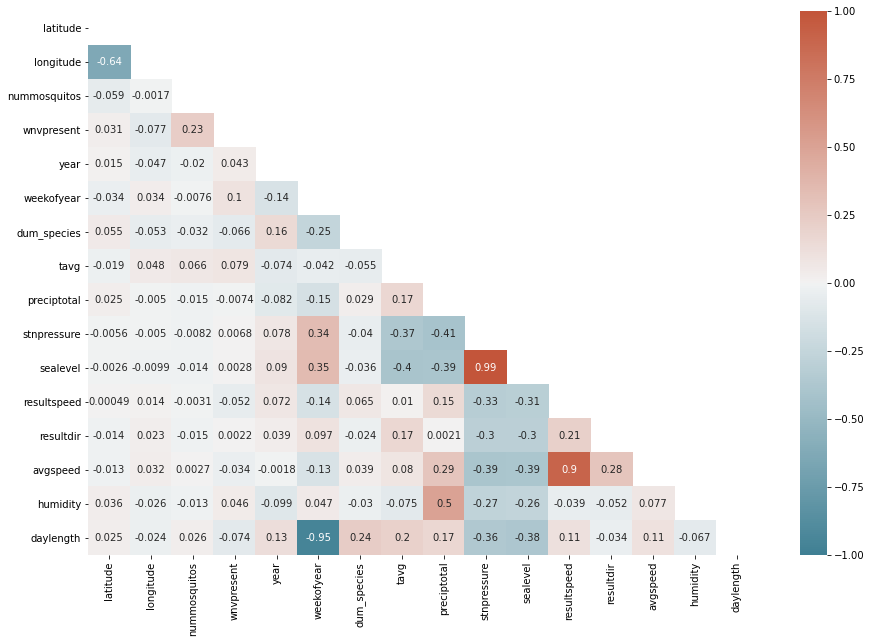

In [134]:
# Preliminary heatmap.

# could give us an indication of what features to drop - multicollinear 

plt.figure(figsize=(15,10))

corr = final_train.corr()


matrix = np.triu(corr)
sns.heatmap(
    corr,
    annot=True,
    mask=matrix,
    vmin=-1,
    vmax=1,
    cmap=(sns.diverging_palette(220, 20, as_cmap=True)),
)

plt.show()

# Feature Engineering ? 

In [135]:
# adding lag of 2 weeks to weather data

for col in ['tavg', 'humidity', 'resultspeed', 'preciptotal']:
    final_train[
        (col + '_lag' + str(14))
    ] = final_train[col].rolling(14, min_periods=1).mean()

In [136]:
for col in ['tavg', 'humidity', 'resultspeed', 'preciptotal']:
    final_test[(col + '_lag' + str(14))] = final_test[col].rolling(14, min_periods=1).mean()

In [145]:
final_train.species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [146]:
final_test

,id,date,species,latitude,longitude,year,weekofyear,latlong,dum_species,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,humidity,daylength,tavg_lag14,humidity_lag14,resultspeed_lag14,preciptotal_lag14
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,2008,24,"41.95469, -87.800991",1,23.888889,0.00,29.310,29.98,9.15,18.0,10.2,50.5,910.0,23.888889,50.5,9.15,0.00
1,2,2008-06-11,CULEX RESTUANS,41.954690,-87.800991,2008,24,"41.95469, -87.800991",2,23.888889,0.00,29.310,29.98,9.15,18.0,10.2,50.5,910.0,23.888889,50.5,9.15,0.00
2,3,2008-06-11,CULEX PIPIENS,41.954690,-87.800991,2008,24,"41.95469, -87.800991",1,23.888889,0.00,29.310,29.98,9.15,18.0,10.2,50.5,910.0,23.888889,50.5,9.15,0.00
3,4,2008-06-11,CULEX SALINARIUS,41.954690,-87.800991,2008,24,"41.95469, -87.800991",0,23.888889,0.00,29.310,29.98,9.15,18.0,10.2,50.5,910.0,23.888889,50.5,9.15,0.00
4,5,2008-06-11,CULEX TERRITANS,41.954690,-87.800991,2008,24,"41.95469, -87.800991",0,23.888889,0.00,29.310,29.98,9.15,18.0,10.2,50.5,910.0,23.888889,50.5,9.15,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,41.925652,-87.633590,2014,40,"41.925652, -87.63359",0,20.833333,0.52,29.065,29.78,7.20,17.0,7.9,77.0,702.5,20.833333,77.0,7.20,0.52
116289,116290,2014-10-02,CULEX TERRITANS,41.925652,-87.633590,2014,40,"41.925652, -87.63359",0,20.833333,0.52,29.065,29.78,7.20,17.0,7.9,77.0,702.5,20.833333,77.0,7.20,0.52
116290,116291,2014-10-02,CULEX TARSALIS,41.925652,-87.633590,2014,40,"41.925652, -87.63359",0,20.833333,0.52,29.065,29.78,7.20,17.0,7.9,77.0,702.5,20.833333,77.0,7.20,0.52
116291,116292,2014-10-02,UNSPECIFIED CULEX,41.925652,-87.633590,2014,40,"41.925652, -87.63359",0,20.833333,0.52,29.065,29.78,7.20,17.0,7.9,77.0,702.5,20.833333,77.0,7.20,0.52


In [ ]:
#  harry only
final_train.to_csv("../datasets/final_train.csv", index=False )
final_test.to_csv("../datasets/final_test.csv", index=False)

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn import 
from imblearn.combine import SMOTETomek